# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
#%connect_info

### Setup params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [3]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

## Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases. They need to be made cumulative as this is how they will be compared to the model.

In [4]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 16371


## Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [5]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH
)

In [6]:
# Results from the manually-calibrated model
manual_results = OpenCLRunner.run_opencl_model_multi(
    repetitions=REPETITIONS,  # Don't use the default, want slightly more robust results
    iterations=ITERATIONS,
    params=PARAMS,
    opencl_dir=OPENCL_DIR, 
    snapshot_filepath=SNAPSHOT_FILEPATH, 
    use_gpu=USE_GPU,
    store_detailed_counts=True,  # Get full info to plot age breakdowns
    multiprocess=False,
    random_ids=False
)

manual_summaries = [x[0] for x in manual_results]
# Store the results as they can be useful as hypothetical observations to test some of the calibration algorithms
pseudo_observations = OpenCLRunner.get_cumulative_new_infections(manual_summaries)

Running models: 100%|██████████| 5/5 [00:48<00:00,  9.65s/it]

.. finished, took 48.28s)


## Plot output summary data

### Total counts of disease status

In [9]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

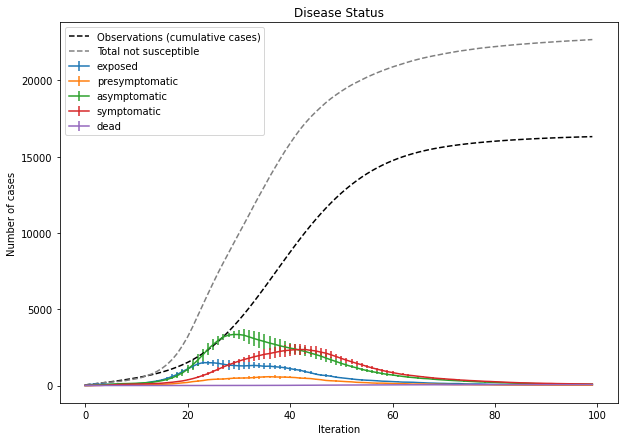

In [8]:
plot_summaries(summaries=manual_summaries, observations=OBSERVATIONS, plot_type="error_bars")

In [9]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [10]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

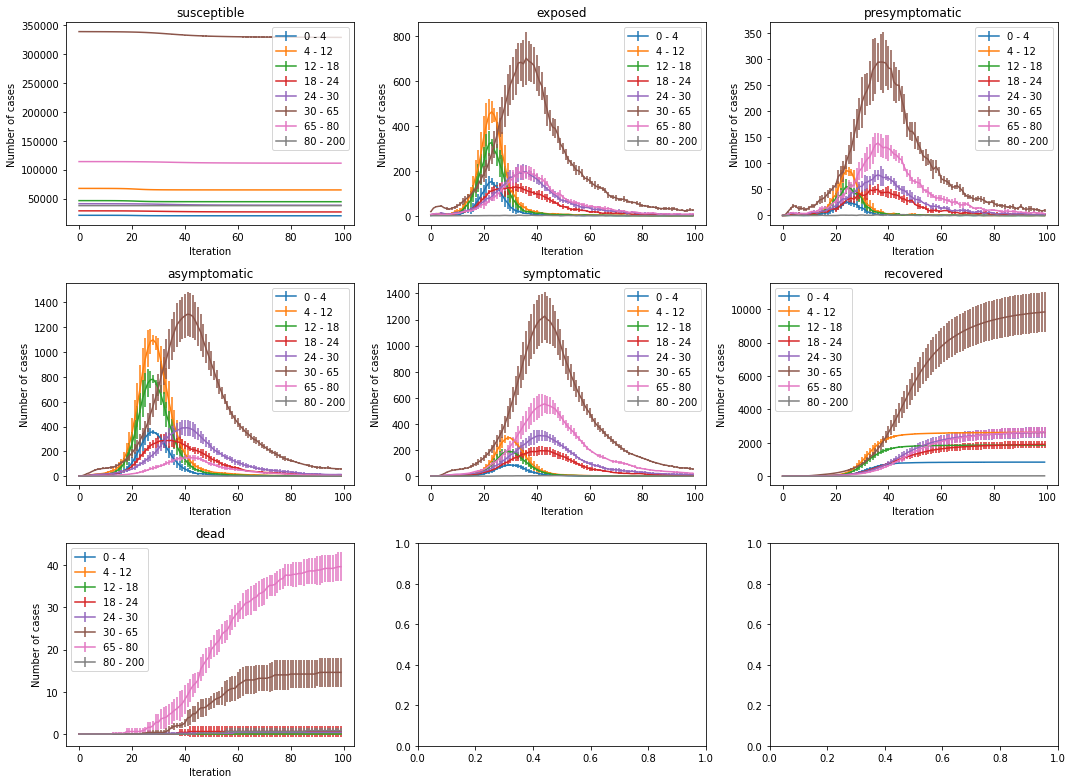

In [11]:
plot_disease_status_by_age(manual_summaries)

### Plot MSOA geodata

#### Load MSOA shapes

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [ ]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

In [ ]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)

## Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. The 'observations' (in the [gam_cases.csv](../../gam_cases.csv)) are the number of new infections per day. The model equivalent of this is to look at the number of non-susceptible people per day (i.e. add up all the _non-susceptible_ disease statuses).

Ultimately two arrays showing the cumulative infections per day need to be compared. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

This is implemented in `opencl_runner.OpenCLRunner.fit_l2` (see [opencl_runner.py](../opencl_runner.py)).

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

## Calibration Parameters

Which parameters will we try to calibrate on?

To begin with lets just try the `current_risk_beta` (a general multiplier for risk at locations).

The `run_model_with_params` function has been created for this purpose. Check it works by re-running the model using default parameters

Running models: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]

.. finished, took 25.6s)
fitness: 45827.06709784077


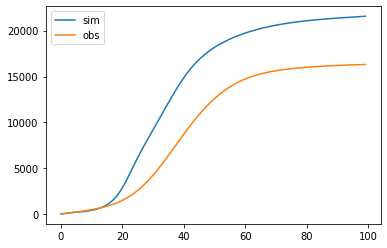

In [7]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions

(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params(np.array([
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale (default defined in the Params class)
    7.0,  #infection_mode (default defined in the Params class)
    1.0,  # presymptomatic (default defined in default.yml)
    0.75, # asymptomatic (default defined in default.yml)
    0.99  #symptomatic (set to 0.99 so that I can check it is different to the default below)
]) , return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)

# Make sure that the parameter value used in the model was set correctly
assert round(float(out_params0.individual_hazard_multipliers[2]),3) == 0.99

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim")
ax.plot(x, obs0, label="obs")
ax.legend()

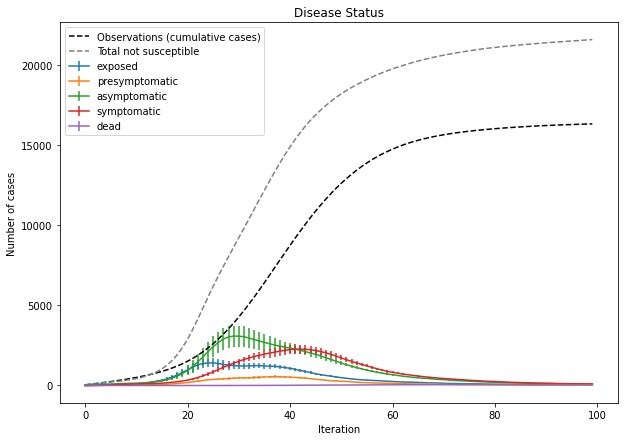

In [10]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

### Calibration

Lots of different methods are available. Simulated annealing? Latin-Hypercube sampling? GA? ABC?

#### Minimization
Start with a simple minimisation algorithm [Nelder-Mead Simplex algorithm](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#nelder-mead-simplex-algorithm-method-nelder-mead) and calibrate on the _current_risk_beta_, the three symptomatic multipliers, and two parameters used to define disease transmissions: _infection_log_scale_ and _infection_mode_.

In [11]:
from scipy.optimize import minimize

x0 = np.array([  # initial guesses for each variable:
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale
    7.0,  #infection_mode
    1.0,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
])

In [ ]:
optimisation_result = minimize(OpenCLRunner.run_model_with_params, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

with open( "./optimisation_result-minimize.pkl", "wb" ) as f:
    pickle.dump( optimisation_result, f)

In [12]:
# Or can optionally load a pickle file
with open( "./optimisation_result-minimize.pkl", "rb" ) as f:
    optimisation_result = pickle.load(f)

Look at the 'optimal' parameters 

In [13]:
np.set_printoptions(suppress=True)
print(optimisation_result.x)

[0.00233679 0.51431182 7.68415629 0.58396896 0.53448522 1.02189788]


Run a model with these parameters to see what happens

In [14]:
#OpenCLRunner.update(store_detailed_counts=True)  # To get the age breakdown
OpenCLRunner.update(repetitions=10) # To reduce some of the confidence intervals

(fitness, sim, obs, out_params, summaries) = \
    OpenCLRunner.run_model_with_params(
        optimisation_result.x, return_full_details=True )

#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)
OpenCLRunner.update(repetitions=REPETITIONS)

Running models: 100%|██████████| 10/10 [01:31<00:00,  9.15s/it]

.. finished, took 91.52s)


For some reason the algorithm found a set of parameters that perform much worse than the initial ones! Compare the graphs below to the ones above.

Original fitness: 45827
Optimised fitness: 11240


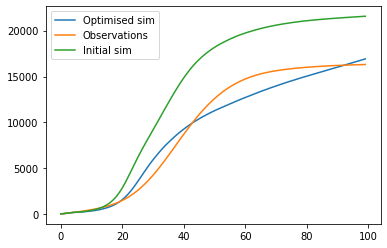

In [15]:
print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")
fig, ax = plt.subplots(1,1)
x = range(len(sim))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries), label="Optimised sim")
ax.plot(x, obs, label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()

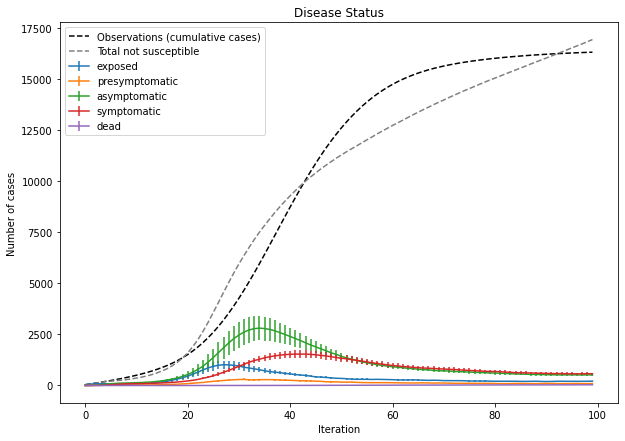

In [17]:
plot_summaries(summaries=summaries, plot_type="error_bars", observations=OBSERVATIONS)
#plot_disease_status_by_age(summaries)

#### Differential evolution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

In [ ]:
from scipy.optimize import differential_evolution
bounds = [  # initial guesses for each variable:
    (0,0.1),  # current_risk_beta, 0.005
    (0,1),  # infection_log_scale, 0.75
    (1,10),  #infection_mode, 7.0
    (0,5),  # presymptomatic multiplier, 1.0
    (0,5), # asymptomatic multiplier, 0.75
    (0,5) # symptomatic multiplier, 1.0 
]

optimisation_result = differential_evolution(OpenCLRunner.run_model_with_params,
                                bounds, updating='immediate', workers=1)
                                #bounds, updating='deferred', workers=2) # paralel version

with open( "./optimisation_result-evolution.pkl", "wb" ) as f:
    pickle.dump( optimisation_result, f)
    
optimisation_result.x, optimisation_result.fun

_TODO: This runs but doesn't terminate after a few days. Need to work out how to find out if it is converging_.

#### Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

Note about installing. It is annoying. I did: 
```
conda install mpi4py
pip install pyabc
```
but also had to follow the first proposed solution [here](https://github.com/ipython/ipyparallel/issues/349) (reinstall setuptools and numpy).

Then I got a really annoying error about "`ValueError: Cell is empty`" which happened to be a pickle problem and was resolved by installing older versions: `cloudpickle==1.4.1 distributed==2.17.0` as per [this post](https://stackoverflow.com/questions/63497235/airflow-scheduler-crashes-when-a-dag-is-run)

 - Also adapted Josie's notebook: https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipynb

In [18]:
import pyabc
# Also quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

To begin with just start with one parameter, the 'presymptomatic multiplier'. Need to decide on a prior distribution that peaks at ~1.0 and has 0 probability for values < 0. A gamma distribution might be OK.

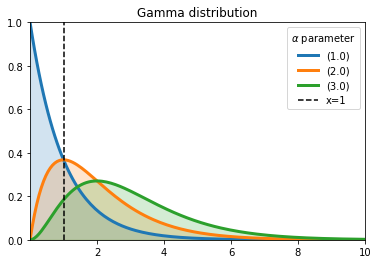

In [19]:
alphas = [1.0, 2.0, 3.0]
x = np.linspace(0.001 ,10, 150)
for alpha in alphas:
    dist = pyabc.Distribution(param=pyabc.RV("gamma", alpha))  # Create the distribution
    y = dist.pdf({"param": x})  # Calculate the pdf at point x
    lines = plt.plot(x, y, label = "(%.1f)"%(alpha), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)

plt.axvline(x=1, ls='--', color="black", label="x=1")
plt.title("Gamma distribution")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [20]:
# Priors. These are actually passed around as a dictionary
prior = pyabc.Distribution(presymp=pyabc.RV("gamma",2.0))

Setup ABC. Currently using a single-process sampler because the model is parallelised, but other options are available (see the [sampler docs](    https://pyabc.readthedocs.io/en/update_rtd/sampler.html))

In [21]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=prior, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [22]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

# Hypothetical cases (for testing) slightly randomised
# (these are already the correct length because they were returned by the model)
#y_observed = np.array([ round(x + random.random()) for x in pseudo_observations ])

In [23]:
# Where to store results
db_path = ("sqlite:///" + os.path.join(".", "abc.db"))

In [24]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

INFO:History:Start <ABCSMC(id=2, start_time=2020-11-18 13:34:11.574974, end_time=None)>


Run ABC

In [ ]:
# Only use 1 iteration for speed while testing
#OpenCLRunner.update(repetitions=1)

#history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
history = abc.run(max_nr_populations=5)

#OpenCLRunner.update(repetitions=REPETITIONS)

# The history object only works if it has the associated database too
with open( "./optimisation_result-abc.pkl", "wb" ) as f:
    pickle.dump( history, f)

Can load the history pickle file, but note that you will also need the sqlite database ('abc.db')

In [25]:
with open( "./optimisation_result-abc.pkl", "rb" ) as f:
    history = pickle.load(f)

Visualise the PDFs

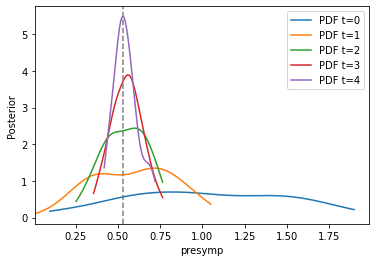

In [30]:
fig, ax = plt.subplots()

for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w,x="presymp", ax=ax,label="PDF t={}".format(t))
#ax.axvline(y_observed, color="k", linestyle="dashed");
ax.axvline(x=0.53, color="grey", linestyle="dashed");
ax.legend()

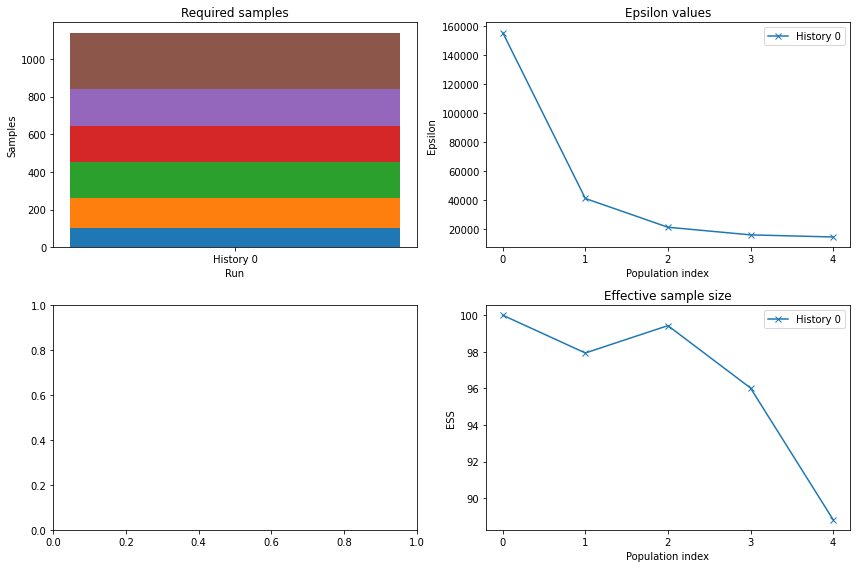

In [27]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Interesting, it thinks that the **presymptomatic multiplier should be around 0.53**, which is lower than expected. Run the simulation again with that number and compare it to the default.

In [31]:
OpenCLRunner.update(repetitions=10)
(fitness, sim, obs, out_params, summaries) = OpenCLRunner.run_model_with_params(np.array([
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale
    7.0,  #infection_mode
    0.53,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
]) , return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)

print(f"fitness: {fitness}")
print(pd.DataFrame({"sim":sim, "pseudo_obs":y_observed, "real_obs1":obs, 
                    "real_obs2":OBSERVATIONS.loc[:len(sim)-1,"Cases"]}))
#list(zip(obs,sim))

Running models: 100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

.. finished, took 26.15s)
fitness: 13922.40465975616
        sim  pseudo_obs  real_obs1  real_obs2
0      37.0          37         37         37
1      75.0          75         75         75
2     115.0         115        115        115
3     156.0         156        156        156
4     199.0         199        199        199
..      ...         ...        ...        ...
95  15842.7       16270      16270      16270
96  15864.6       16281      16281      16281
97  15887.6       16291      16291      16291
98  15912.2       16300      16300      16300
99  15936.8       16309      16309      16309

[100 rows x 4 columns]


Original fitness: 45827
Optimised fitness: 13922


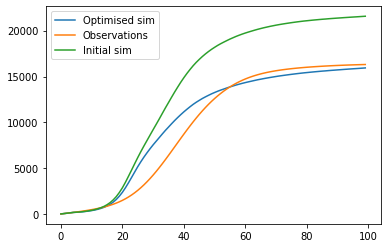

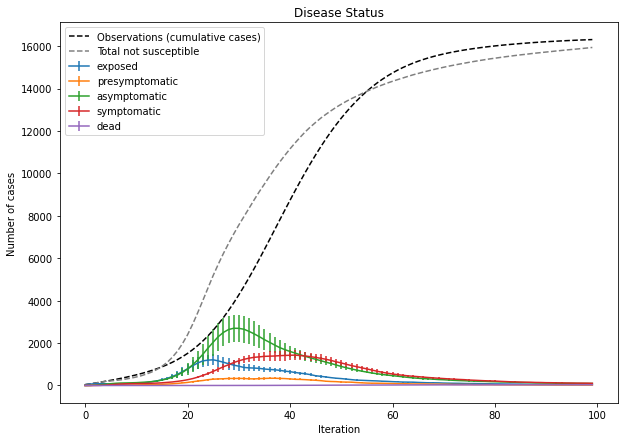

In [33]:
print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")
fig, ax = plt.subplots(1,1)
x = range(len(sim))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries), label="Optimised sim")
ax.plot(x, obs, label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()
plot_summaries(summaries=summaries, plot_type="error_bars", observations=OBSERVATIONS)
#plot_disease_status_by_age(summaries)

#### Approximate Bayesian Computation - Multiple Parameters

As above, but this time with multiple parameters

In [6]:
import pyabc
# Also quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

Define the priors. This time make them all normal distributions, but will decorate them later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

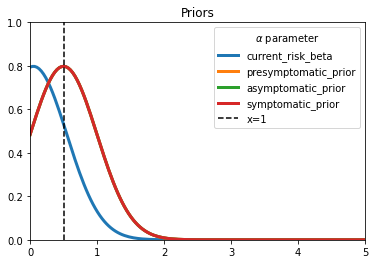

In [7]:
current_risk_beta_rv = pyabc.RV("norm", 0.05, 0.5)
presymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
asymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
symptomatic_rv = pyabc.RV("norm", 0.5, 0.5)

# Note, could create the distribution here (currently done below), then plot the priors directly using, e.g. 
#   y= p riors['current_risk_beta_prior'].pdf(x)
# but for some reason decorating them with the LowerBoundDecorator breaks the call to pdf()

x = np.linspace(-0 ,5, 150)
lines = plt.plot(x, pyabc.Distribution(param=current_risk_beta_rv).pdf({"param": x}),
                 label = "current_risk_beta", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=presymptomatic_rv).pdf({"param": x}),
                 label = "presymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=asymptomatic_rv).pdf({"param": x}),
                 label = "asymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=symptomatic_rv).pdf({"param": x}),
                 label = "symptomatic_prior", lw = 3)

plt.autoscale(tight=True)

plt.axvline(x=0.5, ls='--', color="black", label="x=1")
plt.title("Priors")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [8]:
# Decorate the RVs so that they wont go below 0 and create the prior distribution 

priors = pyabc.Distribution(
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0),
    presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0)
    )

#current_risk_beta_prior = pyabc.LowerBoundDecorator(current_risk_beta_prior, 0.0)
#presymptomatic_prior = pyabc.LowerBoundDecorator(presymptomatic_prior, 0.0)
#asymptomatic_prior = pyabc.LowerBoundDecorator(asymptomatic_prior, 0.0)
#symptomatic_prior = pyabc.LowerBoundDecorator(symptomatic_prior, 0.0)

Define the ABC algorithm. **NOTE: I have had to define one model for each prior, not sure what the implications of this are, e.g. if the interations between the parameters are nonlinear**

In [9]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [10]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [12]:
db_path = ("sqlite:///" + os.path.join(".", "abc2.db"))

In [ ]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

Run ABC

In [ ]:
# Only use 1 iteration for speed while testing
#OpenCLRunner.update(repetitions=1)

#history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
history = abc.run(max_nr_populations=1)  # JUST ONE POP TO SEE IF IT WORKS

#OpenCLRunner.update(repetitions=REPETITIONS)

# The history object only works if it has the associated database too
with open( "./optimisation_result-abc2.pkl", "wb" ) as f:
    pickle.dump( history, f)

Can load the history pickle file, but note that you will also need the sqlite database ('abc2.db')

In [9]:
with open( "./optimisation_result-abc2.pkl", "rb" ) as f:
    history = pickle.load(f)

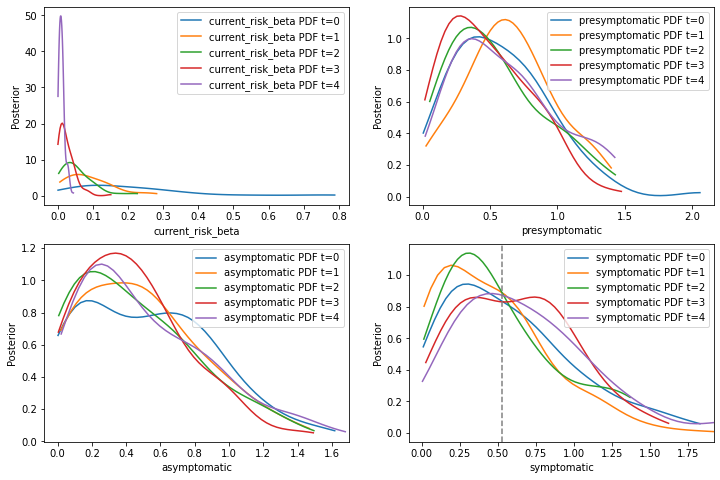

In [26]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}")
        ax.legend()
        
#ax.axvline(y_observed, color="k", linestyle="dashed");
ax.axvline(x=0.53, color="grey", linestyle="dashed");


As above, but this time do a separate plot for each population

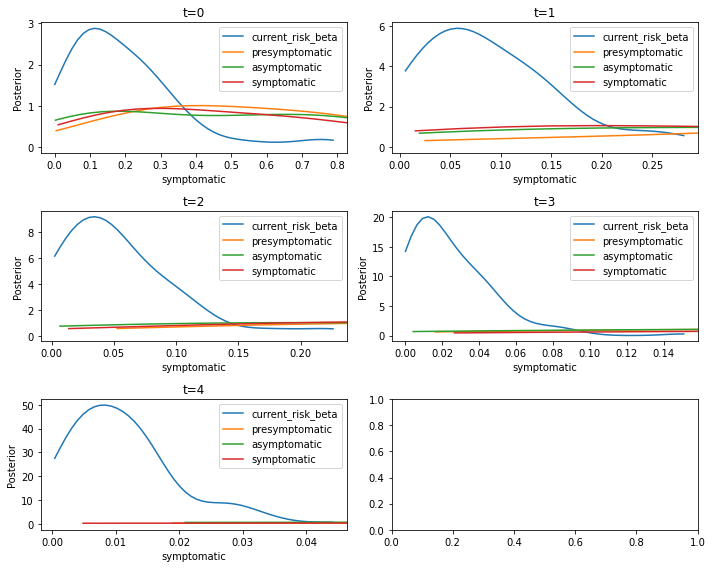

In [35]:
fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for t in range(history.max_t + 1):
    ax = axes.flat[t]
    for i, param in enumerate(priors.keys()):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param}")
    ax.legend()
    ax.set_title(f"t={t}")
        
fig.tight_layout()


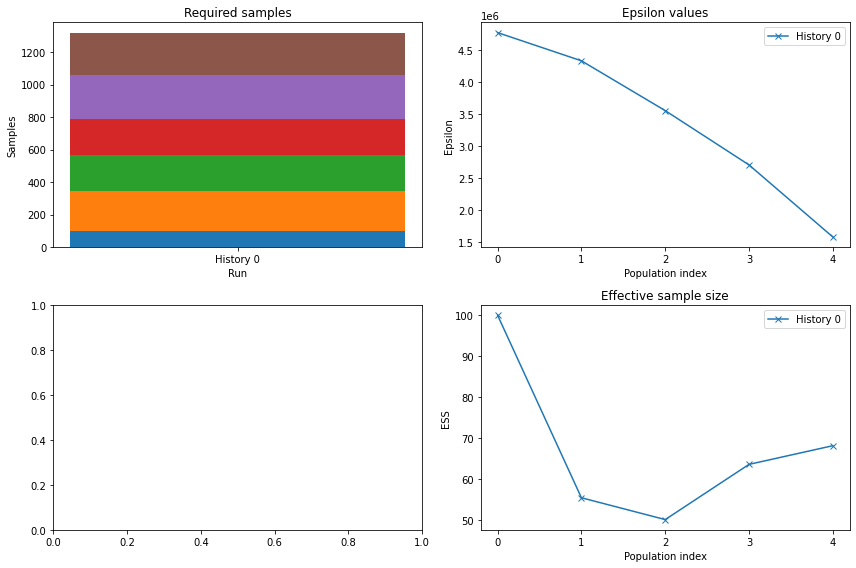

In [19]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Re-run with the mean parameters XXXX HERE - need to add a return_full_details option to `run_model_with_params_abc`

In [23]:
history.get_distribution()

(name  asymptomatic  current_risk_beta  presymptomatic  symptomatic
 id                                                                
 403       0.960955           0.007259        0.834227     1.131657
 404       1.020369           0.003074        0.209838     1.455726
 405       0.245780           0.044255        0.251751     0.004860
 406       0.510611           0.001801        0.915492     1.033929
 407       0.788236           0.014847        0.339421     0.085045
 ..             ...                ...             ...          ...
 498       0.313915           0.006445        0.868904     0.842752
 499       0.244003           0.014777        0.554818     0.994555
 500       0.085367           0.026146        0.151945     0.284662
 501       0.828460           0.000846        0.171672     0.235972
 502       0.437384           0.004496        0.377818     1.342923
 
 [100 rows x 4 columns],
 array([0.01037008, 0.00202723, 0.00666584, 0.00409055, 0.01227884,
        0.00713635, 0

In [ ]:
OpenCLRunner.update(repetitions=10)
(fitness, sim, obs, out_params, summaries) = OpenCLRunner.run_model_with_params_abc(np.array([
    0.00235,  # current_risk_beta
    0.35,  # infection_log_scale
    7.0,  #infection_mode
    0.53,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
]) , return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)

print(f"fitness: {fitness}")
print(pd.DataFrame({"sim":sim, "pseudo_obs":y_observed, "real_obs1":obs, 
                    "real_obs2":OBSERVATIONS.loc[:len(sim)-1,"Cases"]}))
#list(zip(obs,sim))

#### Machine learning based (neural) density estimation

Something that Sebastion Schmon is experimenting with that I want to try. SBI (simulation-based inference, https://www.mackelab.org/sbi/). I think the idea is that you train a neural network to learn the model, then use that to generate a posterior.